In [1]:
import scipy.io
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from model.utils import loadHSI,calculate_aligned_accuracy
from lund.utils import GraphExtractor, diffusion_distance
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from scipy.spatial.distance import pdist, squareform

Xmat = scipy.io.loadmat('X.mat')
Ymat = scipy.io.loadmat('Y.mat')

In [2]:
X_scipy = Xmat["X"]
GT_scipy = Ymat['Y']

In [3]:
def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()

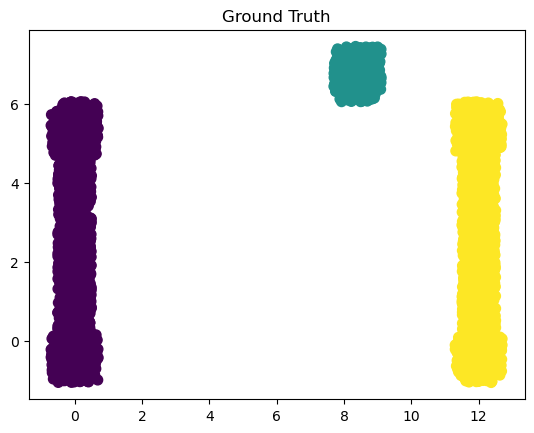

(6581, 2)


In [4]:
plot_clusters(X_scipy, GT_scipy, "Ground Truth")
print(X_scipy.shape)

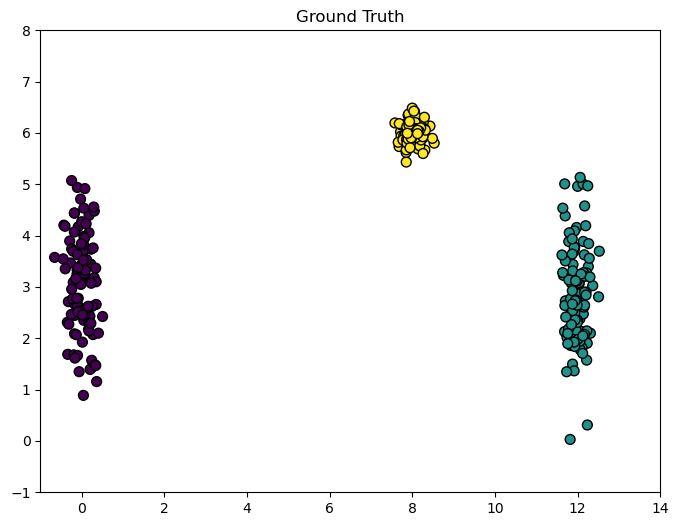

X shape: (300, 2)
GT shape: (300,)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate data for clusters
# Left cluster
cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
cluster_1_y = np.random.normal(loc=3, scale=1.0, size=100)

# Center cluster
cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# Right cluster
cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
cluster_2_y = np.random.normal(loc=3, scale=1.0, size=100)

# Combine x and y coordinates for each cluster into a single 2D array
cluster_1 = np.column_stack((cluster_1_x, cluster_1_y))
cluster_2 = np.column_stack((cluster_2_x, cluster_2_y))
cluster_3 = np.column_stack((cluster_3_x, cluster_3_y))

# Combine all clusters into one 2D array
X = np.vstack((cluster_1, cluster_2, cluster_3))

# Combine y coordinates for ground truth labels
GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y))

# Create labels for clusters
labels = np.array([0] * 100 + [1] * 100 + [2] * 100)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-1, 14)
plt.ylim(-1, 8)
plt.show()

print("X shape:", X.shape)
print("GT shape:", GT.shape)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate data for the first cluster
# # left clusters
# cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_1_y = np.random.normal(loc=5, scale=0.5, size=100)
# cluster_4_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_4_y = np.random.normal(loc=1, scale=0.5, size=100)

# # center cluster
# cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
# cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# # Generate data for the second cluster
# # right clusters
# cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_2_y = np.random.normal(loc=5, scale=0.5, size=100)
# cluster_5_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_5_y = np.random.normal(loc=1, scale=0.5, size=100)

# # Combine all clusters
# X = np.hstack((cluster_1_x, cluster_2_x, cluster_3_x, cluster_4_x, cluster_5_x))
# GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y, cluster_4_y, cluster_5_y))

# # Create labels for clusters
# labels = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100)

# # Plot the data with clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X, GT, c=labels, cmap='viridis', s=50, edgecolor='k')
# plt.title('Ground Truth')
# plt.xlim(-1, 14)
# plt.ylim(-1, 8)
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Generate data for the first cluster
# # left clusters
# cluster_1_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_1_y = np.random.normal(loc=4, scale=0.5, size=100)
# cluster_4_x = np.random.normal(loc=0, scale=0.2, size=100)
# cluster_4_y = np.random.normal(loc=2, scale=0.5, size=100)

# # center cluster
# cluster_3_x = np.random.normal(loc=8, scale=0.2, size=100)
# cluster_3_y = np.random.normal(loc=6, scale=0.2, size=100)

# # Generate data for the second cluster
# # right clusters
# cluster_2_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_2_y = np.random.normal(loc=4, scale=0.5, size=100)
# cluster_5_x = np.random.normal(loc=12, scale=0.2, size=100)
# cluster_5_y = np.random.normal(loc=2, scale=0.5, size=100)

# # Combine all clusters
# X = np.hstack((cluster_1_x, cluster_2_x, cluster_3_x, cluster_4_x, cluster_5_x))
# GT = np.hstack((cluster_1_y, cluster_2_y, cluster_3_y, cluster_4_y, cluster_5_y))

# # Create labels for clusters
# labels = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100 + [4] * 100)

# # Plot the data with clusters
# plt.figure(figsize=(8, 6))
# plt.scatter(X, GT, c=labels, cmap='viridis', s=50, edgecolor='k')
# plt.title('Ground Truth')
# plt.xlim(-1, 14)
# plt.ylim(-1, 8)
# plt.show()

# print(X.shape,'\n\n', GT.shape)

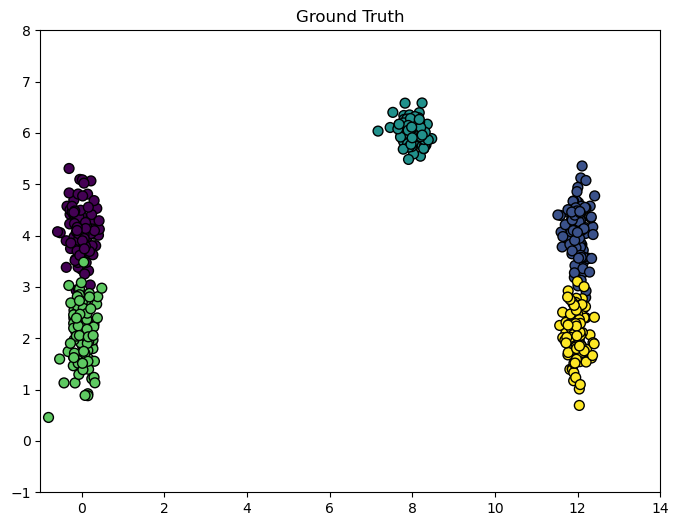

X shape: (500, 2)
X shape: (100, 10)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data for clusters
# Left clusters
cluster_1 = np.column_stack((np.random.normal(loc=0, scale=0.2, size=100), 
                             np.random.normal(loc=4, scale=0.5, size=100)))
cluster_4 = np.column_stack((np.random.normal(loc=0, scale=0.2, size=100), 
                             np.random.normal(loc=2, scale=0.5, size=100)))

# Center cluster
cluster_3 = np.column_stack((np.random.normal(loc=8, scale=0.2, size=100), 
                             np.random.normal(loc=6, scale=0.2, size=100)))

# Right clusters
cluster_2 = np.column_stack((np.random.normal(loc=12, scale=0.2, size=100), 
                             np.random.normal(loc=4, scale=0.5, size=100)))
cluster_5 = np.column_stack((np.random.normal(loc=12, scale=0.2, size=100), 
                             np.random.normal(loc=2, scale=0.5, size=100)))

# Combine all clusters
X = np.vstack((cluster_1, cluster_2, cluster_3, cluster_4, cluster_5))
labels = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-1, 14)
plt.ylim(-1, 8)
plt.show()

print("X shape:", X.shape)
X = np.reshape(X, (100,10))
print("X shape:", X.shape)

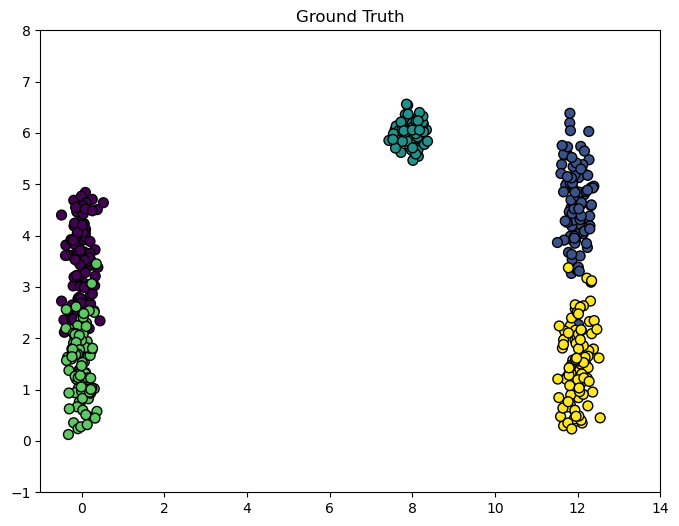

X shape: (500, 2)
X shape: (100, 10)


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data for clusters
# Left clusters (dumbbell shapes)
cluster_1_left = np.column_stack((np.random.normal(loc=0, scale=0.2, size=50), 
                                  np.random.normal(loc=4, scale=0.5, size=50)))
cluster_1_right = np.column_stack((np.random.normal(loc=0, scale=0.2, size=50), 
                                   np.random.normal(loc=3, scale=0.5, size=50)))
cluster_4_left = np.column_stack((np.random.normal(loc=0, scale=0.2, size=50), 
                                  np.random.normal(loc=2, scale=0.5, size=50)))
cluster_4_right = np.column_stack((np.random.normal(loc=0, scale=0.2, size=50), 
                                   np.random.normal(loc=1, scale=0.5, size=50)))

# Center cluster
cluster_3 = np.column_stack((np.random.normal(loc=8, scale=0.2, size=100), 
                             np.random.normal(loc=6, scale=0.2, size=100)))

# Right clusters (dumbbell shapes)
cluster_2_left = np.column_stack((np.random.normal(loc=12, scale=0.2, size=50), 
                                  np.random.normal(loc=4, scale=0.5, size=50)))
cluster_2_right = np.column_stack((np.random.normal(loc=12, scale=0.2, size=50), 
                                   np.random.normal(loc=5, scale=0.5, size=50)))
cluster_5_left = np.column_stack((np.random.normal(loc=12, scale=0.2, size=50), 
                                  np.random.normal(loc=2, scale=0.5, size=50)))
cluster_5_right = np.column_stack((np.random.normal(loc=12, scale=0.2, size=50), 
                                   np.random.normal(loc=1, scale=0.5, size=50)))

# Combine all clusters
X = np.vstack((cluster_1_left, cluster_1_right, cluster_2_left, cluster_2_right, 
               cluster_3, cluster_4_left, cluster_4_right, cluster_5_left, cluster_5_right))
labels = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100 + [4]*100)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Ground Truth')
plt.xlim(-1, 14)
plt.ylim(-1, 8)
plt.show()

print("X shape:", X.shape)
X = np.reshape(X, (100, 10))
print("X shape:", X.shape)

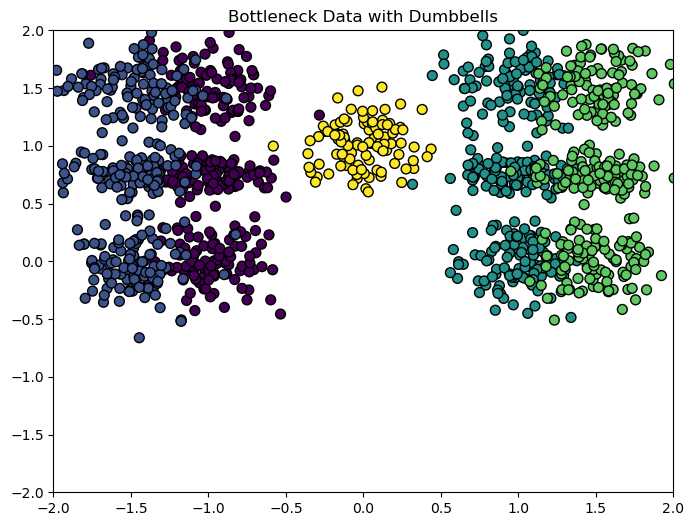

X shape: (1300, 2)


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data for clusters
# Left clusters (dumbbell shapes)
cluster_1_top = np.column_stack((np.random.normal(loc=-1, scale=0.2, size=100), 
                                 np.random.normal(loc=1.5, scale=0.2, size=100)))
cluster_1_handle = np.column_stack((np.random.normal(loc=-1, scale=0.2, size=100), 
                                    np.random.normal(loc=0.75, scale=0.1, size=100)))
cluster_1_bottom = np.column_stack((np.random.normal(loc=-1, scale=0.2, size=100), 
                                    np.random.normal(loc=0, scale=0.2, size=100)))

cluster_4_top = np.column_stack((np.random.normal(loc=-1.5, scale=0.2, size=100), 
                                 np.random.normal(loc=1.5, scale=0.2, size=100)))
cluster_4_handle = np.column_stack((np.random.normal(loc=-1.5, scale=0.2, size=100), 
                                    np.random.normal(loc=0.75, scale=0.1, size=100)))
cluster_4_bottom = np.column_stack((np.random.normal(loc=-1.5, scale=0.2, size=100), 
                                    np.random.normal(loc=0, scale=0.2, size=100)))

# Right clusters (dumbbell shapes)
cluster_2_top = np.column_stack((np.random.normal(loc=1, scale=0.2, size=100), 
                                 np.random.normal(loc=1.5, scale=0.2, size=100)))
cluster_2_handle = np.column_stack((np.random.normal(loc=1, scale=0.2, size=100), 
                                    np.random.normal(loc=0.75, scale=0.1, size=100)))
cluster_2_bottom = np.column_stack((np.random.normal(loc=1, scale=0.2, size=100), 
                                    np.random.normal(loc=0, scale=0.2, size=100)))

cluster_5_top = np.column_stack((np.random.normal(loc=1.5, scale=0.2, size=100), 
                                 np.random.normal(loc=1.5, scale=0.2, size=100)))
cluster_5_handle = np.column_stack((np.random.normal(loc=1.5, scale=0.2, size=100), 
                                    np.random.normal(loc=0.75, scale=0.1, size=100)))
cluster_5_bottom = np.column_stack((np.random.normal(loc=1.5, scale=0.2, size=100), 
                                    np.random.normal(loc=0, scale=0.2, size=100)))

# Center cluster
cluster_3 = np.column_stack((np.random.normal(loc=0, scale=0.2, size=100), 
                             np.random.normal(loc=1, scale=0.2, size=100)))

# Combine all clusters
X = np.vstack((cluster_1_top, cluster_1_handle, cluster_1_bottom,
               cluster_4_top, cluster_4_handle, cluster_4_bottom,
               cluster_2_top, cluster_2_handle, cluster_2_bottom,
               cluster_5_top, cluster_5_handle, cluster_5_bottom,
               cluster_3))
labels = np.array([0]*300 + [1]*300 + [2]*300 + [3]*300 + [4]*100)

# Plot the data with clusters
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('Bottleneck Data with Dumbbells')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

print("X shape:", X.shape)

In [ ]:
# kde = KernelDensity(bandwidth=1.0)
# X = X.reshape(-1, 1)
# print(X.shape, "HERE")
# kde.fit(X)


# log_density = kde.score_samples(X)
# p = np.exp(log_density)
# print(p.shape)

# graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10, NEigs=X.shape[0])
# G = graph_extractor.extract_graph(X)


# C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# accuracy = calculate_aligned_accuracy(GT, C)
# print("Aligned Accuracy:", accuracy)

# plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
# plot_clusters(X, GT, "Ground Truth")

(300, 2)
(300,)
Initialized with NEigs = 300 (type: <class 'int'>)


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


debugguing eigenvales length is  300
(300,) This is GT
entered lund
Number of Eigenvalues: 300
Number of Eigenvectors: (300, 300)
Shape of G['EigenVecs']: (300, 300)
Shape of G['EigenVals']: (300,)
Shape of DiffusionDistance: (300, 300)
Shape of p: (300,)
m_sorting: [229 151  56  54  79  14  46  52  92  82  90 218  50  12  95  59  15 275
  68  60  49  47  64  48  11  30  31  19   4  80  10   6  38  55   2  16
  76  42   9  33  61  66  91  21 268  69 128 106   0 155 278   8 256  27
 187 159  24 153  99 270 118  13  88 279  43  35 287  74  34  65  22  40
 124  77 164  57 259 190  89 126 193 298 150  44 234 286 121 245  75 179
 197 239 119  78  93  23 152  41  51 170  17 167 191  20 269  36 261 130
 195  18 216  53  87 253 137  70 215 219 273 148 161 192 113 211  72 294
 257 144  25 282 299 201 232 226  45 189 133 114 115 168   3 244   1 157
   5 221 264 249 178  58 196 227 246  98  26 166 214 174  73 160 180 162
 260  97 111  67 277 158 107  32 136 213 110 266 296  96 285 254 280 185
 28

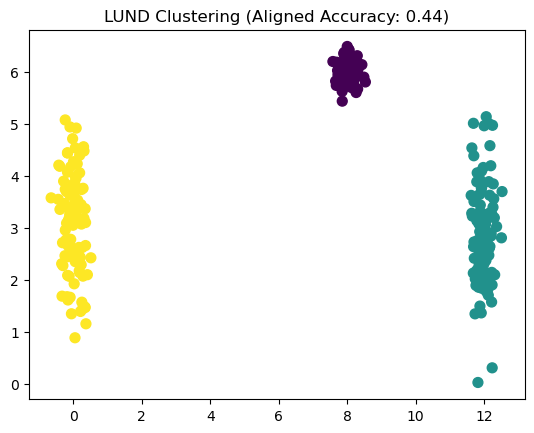

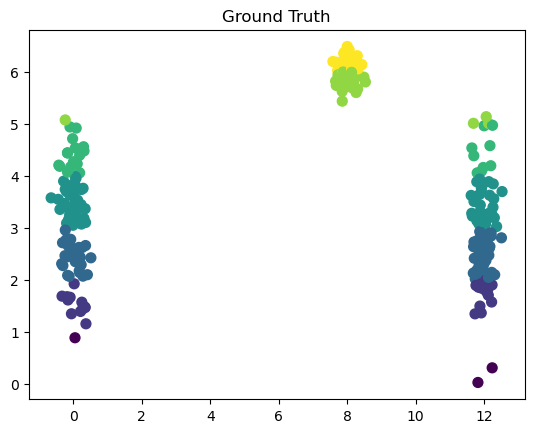

In [10]:
print(X.shape)
kde = KernelDensity(bandwidth=1.0).fit(X)
# kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10, NEigs=300)
G = graph_extractor.extract_graph(X)


print(GT.shape, "This is GT")

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)

GT = GT.astype(int)
C = C.astype(int)
accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)
print("GT shape", GT.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0).fit(X)
# kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)
print(p.shape)
graph_extractor = GraphExtractor(sigma = 0.8600, DiffusionNN = 6578, NEigs= 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep):

    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at t={timestep}')
    plt.show()


for timestep in [10, 20, 30, 40]:
    plot_diffusion_distance(G, timestep)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 30, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")

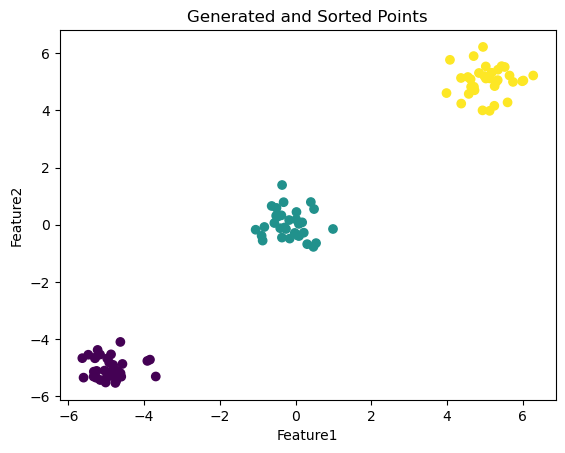

GRID SIZE:  10
Data shape: (99, 2)
Initialized with NEigs = 100 (type: <class 'int'>)
debugguing eigenvales length is  99
entered lund
Number of Eigenvalues: 99
Number of Eigenvectors: (99, 99)
Shape of G['EigenVecs']: (99, 99)
Shape of G['EigenVals']: (99,)
Shape of DiffusionDistance: (99, 99)
Shape of p: (99,)
m_sorting: [12 47 82 30 17 77 16 69 29  8 75 71 21 13 20 32 19 31 88 22  5 72 73 68
  0 96 93 15 27  4 14 28  6 78 10 90 81 70 94 74 66 25  7 11 84 80 89 87
 76  2 91 79 67  9 23  1  3 26 18 24 43 49 51 56 48 60 38 40 35 55 59 44
 53 61 45 52 64 42 41 63 65 46 58 39 34 50 37 36 33 54 57 83 92 85 86 97
 62 95 98]
Number of clusters K: 3
Number of clusters: 3
Aligned Accuracy: 1.0


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1272: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


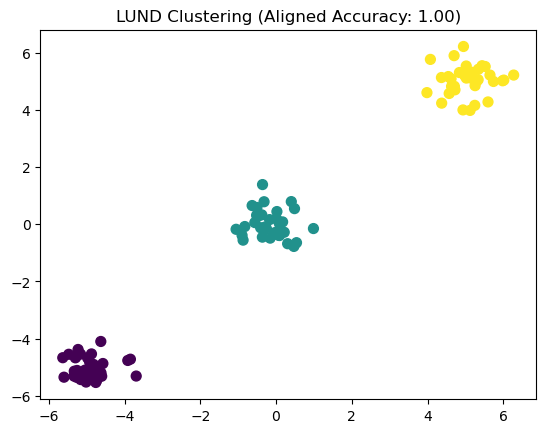

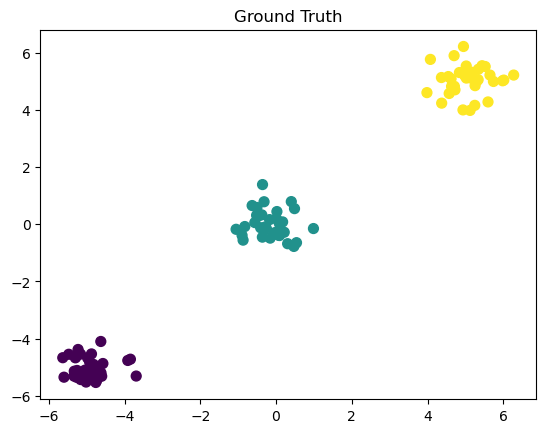

In [7]:
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_moons, make_blobs, make_classification, make_circles
from sklearn.manifold import TSNE
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import pdist, squareform
from lund.lund import LearningbyUnsupervisedNonlinearDiffusion
from lund.utils import GraphExtractor, diffusion_distance
from model.utils import loadHSI,calculate_aligned_accuracy
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd

# data_path, gt_path, data_name, gt_name = '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_corrected.mat', '/Users/seoli/Desktop/DIAMONDS/Tufts2024/data/SalinasA_gt.mat', 'salinasA_corrected', 'salinasA_gt'


# X, M, N, D, HSI, GT, Y, n, K = loadHSI(data_path, gt_path, data_name, gt_name)
n_samples = 100
n_clusters = 3
centers = [(-5, -5), (0, 0), (5, 5)]
cluster_std = 0.5

# Generate points for each cluster
points = []
labels = []

for i, center in enumerate(centers):
    x = np.random.normal(center[0], cluster_std, n_samples // n_clusters)
    y = np.random.normal(center[1], cluster_std, n_samples // n_clusters)
    cluster_points = np.column_stack((x, y))
    points.append(cluster_points)
    labels.append(np.full(n_samples // n_clusters, i))

points = np.vstack(points)
labels = np.concatenate(labels)

df = pd.DataFrame(points, columns=['Feature1', 'Feature2'])
df['Label'] = labels
df_sorted = df.sort_values(by=['Feature1', 'Feature2']).reset_index(drop=True)

X = df_sorted[['Feature1', 'Feature2']].values
GT = df_sorted['Label'].values

plt.scatter(X[:, 0], X[:, 1], c=GT, cmap='viridis')
plt.title('Generated and Sorted Points')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

scipy.io.savemat('data.mat', {'X': X, 'GT': GT})


grid_size = int(np.ceil(np.sqrt(X.shape[0])))
print("GRID SIZE: ", grid_size)

print("Data shape:", X.shape)

# GT = GT - 1
# HSI = X.reshape((M, N, D))
# Hyperparameters = {
#     'Sigma': 1.0,
#     'DiffusionNN': 10,
    
# }

kde = KernelDensity(bandwidth=1.0)
kde.fit(X)
log_density = kde.score_samples(X)
p = np.exp(log_density)

graph_extractor = GraphExtractor(sigma = 0.5, DiffusionNN = 10)
G = graph_extractor.extract_graph(X)


def plot_diffusion_distance(G, timestep, log_scale=False):
    if log_scale:
        timestep = np.log10(timestep)
    distances, embedding = diffusion_distance(G, timestep)
    plt.figure(figsize=(10, 8))
    sns.heatmap(distances, cmap='viridis')
    plt.title(f'Diffusion Distance Matrix at log10(t)={timestep:.2f}' if log_scale else f'Diffusion Distance Matrix at t={timestep}')
    plt.show()
    
# for timestep in [10, 40, 80, 100]:
#     print(f"Plotting for log10(t)={np.log10(timestep):.2f}")
#     plot_diffusion_distance(G, timestep, log_scale=False)

C, K, Dt = LearningbyUnsupervisedNonlinearDiffusion(X, 150, G, p)


# print("Cluster labels:", C)
# print("GT",GT)
print("Number of clusters:", K)

accuracy = calculate_aligned_accuracy(GT, C)
print("Aligned Accuracy:", accuracy)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(title)
    plt.show()
    
def plot_kde_density(X, title):
    # Create the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=X[:, 0], y=X[:, 1], cmap='viridis', fill=True, levels=20, thresh=0)
    plt.scatter(X[:, 0], X[:, 1], c='red', s=5, edgecolor='k')
    plt.title(title)
    plt.show()


plot_clusters(X, C, f"LUND Clustering (Aligned Accuracy: {accuracy:.2f})")
plot_clusters(X, GT, "Ground Truth")
# plot_kde_density(X, "KDE Density Estimation")